# Clasificación de Texto con BERT y Hugging Face

## 🐦💬 Análisis de Sentimientos en Tweets con BERT Multilingüe 🤖🌍❤️

Explorando el poder de los Transformers 🤖 para detectar emociones 😡😐😄 en mensajes cortos de Twitter 🐦 multilenguaje.

📊📝 Proyecto de Clasificación de Texto

Dataset: Twitter Entity Sentiment Analysis (Kaggle)

Modelo: BERT Multilingual Cased (Hugging Face Transformers)

Tarea: Clasificación de sentimientos en cuatro categorías

🟥 Negativo (0)

🟨 Neutro (1)

🟩 Positivo (2)

⚪ Irrelevante (3)

[Enlace al dataset:](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/code) Revisemos los Tweets

## Autores:
### Yasmin Johanna Garcia
### Javier Ricardo Muñoz 

In [1]:
!pip -q install -U transformers datasets evaluate accelerate scikit-learn

In [2]:
# Importaciones esenciales
import os, random, numpy as np, torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
import evaluate
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime

# Reproducibilidad
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Device: {device}")
if torch.cuda.is_available():
    print(f"✅ GPU detectada: {torch.cuda.get_device_name(0)}")

# Versiones rápidas (útil para depurar)
import transformers, datasets
print("🧰 Versions -> transformers:", transformers.__version__, 
      "| datasets:", datasets.__version__, 
      "| torch:", torch.__version__)


c:\Users\yasmi\anaconda\envs\torch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🖥️ Device: cuda
✅ GPU detectada: NVIDIA GeForce RTX 3050 Laptop GPU
🧰 Versions -> transformers: 4.56.1 | datasets: 4.0.0 | torch: 2.5.1+cu121


# Cargar el Dataset 🚀

In [ ]:
#!pip install kagglehub

In [ ]:
import kagglehub

# Descargar el dataset
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")
print("Path to dataset files:", path)


In [ ]:
import os
import pandas as pd

# Ruta que imprimió kagglehub
print("Archivos en la carpeta descargada:")
print(os.listdir(path))

# Cargar CSV principal
csv_path = os.path.join(path, "twitter_training.csv") 
df = pd.read_csv(csv_path)

print("Forma:", df.shape)
print(df.head(10))



Archivos en la carpeta descargada:
['twitter_training.csv', 'twitter_validation.csv']
Forma: (74681, 4)
   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   
5  2402  Borderlands  Positive   
6  2402  Borderlands  Positive   
7  2402  Borderlands  Positive   
8  2402  Borderlands  Positive   
9  2402  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     
5  So I spent a few hours making something for fu...     
6  So I spent a couple of hours doing something f...     
7  So I spent a few hours doing something for fun...     

## Tratamiento del Dataset

In [12]:
# Renombrar columnas
df.columns = ["tweet_id", "entity", "sentiment", "text"]

# Mapeo de etiquetas a números
label2id = {"Negative": 0, "Neutral": 1, "Positive": 2, "Irrelevant": 3}
id2label = {v: k for k, v in label2id.items()}

df["label"] = df["sentiment"].map(label2id)

# Verificamos
print(df.head(10)[["text", "sentiment", "label"]])
print("\nDistribución de clases:")
print(df["label"].value_counts())


                                                text sentiment  label
0  I am coming to the borders and I will kill you...  Positive      2
1  im getting on borderlands and i will kill you ...  Positive      2
2  im coming on borderlands and i will murder you...  Positive      2
3  im getting on borderlands 2 and i will murder ...  Positive      2
4  im getting into borderlands and i can murder y...  Positive      2
5  So I spent a few hours making something for fu...  Positive      2
6  So I spent a couple of hours doing something f...  Positive      2
7  So I spent a few hours doing something for fun...  Positive      2
8  So I spent a few hours making something for fu...  Positive      2
9  2010 So I spent a few hours making something f...  Positive      2

Distribución de clases:
label
0    22542
2    20831
1    18318
3    12990
Name: count, dtype: int64


In [17]:
# Nos quedamos solo con columnas necesarias
df_clean = df[["text", "label"]].dropna()

# Confirmamos
print(df_clean.head(5))
print("\nDistribución de clases:")
print(df_clean["label"].value_counts())


                                                text  label
0  I am coming to the borders and I will kill you...      2
1  im getting on borderlands and i will kill you ...      2
2  im coming on borderlands and i will murder you...      2
3  im getting on borderlands 2 and i will murder ...      2
4  im getting into borderlands and i can murder y...      2

Distribución de clases:
label
0    22358
2    20654
1    18108
3    12875
Name: count, dtype: int64


# Distribución Por Categoria 

C:\Users\yasmi\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


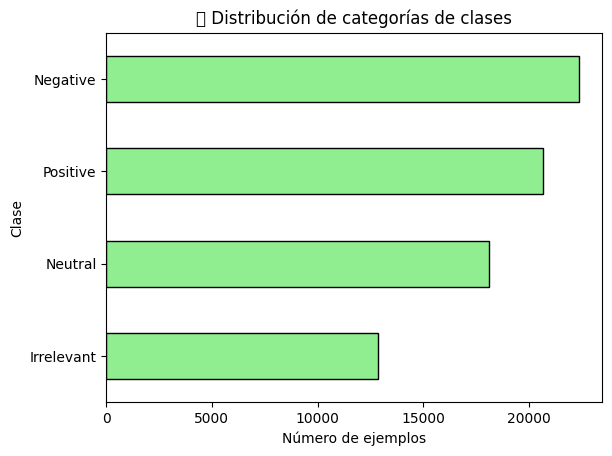

In [37]:
label_names = {0: "Negative", 1: "Neutral", 2: "Positive", 3: "Irrelevant"}

df_clean["label"].map(label_names).value_counts(ascending=True).plot.barh(color="lightgreen", edgecolor="black")

plt.title("📊 Distribución de categorías de clases")
plt.xlabel("Número de ejemplos")
plt.ylabel("Clase")
plt.show()


C:\Users\yasmi\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


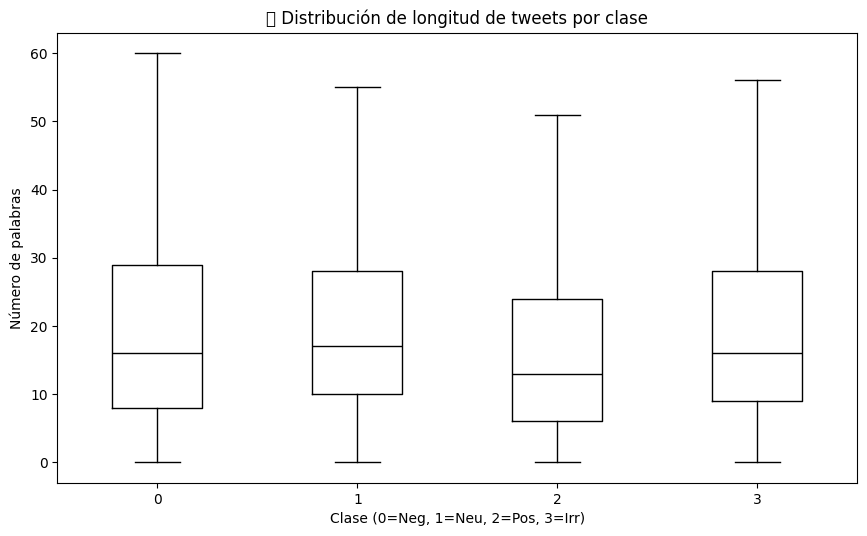

In [38]:
# Calcular cantidad de palabras por tweet
df_clean["Palabras_por_Texto"] = df_clean["text"].str.split().apply(len)

# Boxplot por clase (usando label numérico)
df_clean.boxplot("Palabras_por_Texto", by="label", grid=False, showfliers=False, color="black", figsize=(10,6))

plt.suptitle("")
plt.title("📊 Distribución de longitud de tweets por clase")
plt.xlabel("Clase (0=Neg, 1=Neu, 2=Pos, 3=Irr)")
plt.ylabel("Número de palabras")
plt.show()


# 📦 Tokenizador

Modelo que trata mas de 100 idiomas 🔎

In [18]:
from transformers import AutoTokenizer

# Elegimos un modelo multilingüe
MODEL_NAME = "bert-base-multilingual-cased"

# Cargamos el tokenizador
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Probamos tokenización con un ejemplo
example = df["text"].iloc[0]
tokens = tokenizer(example, padding="max_length", truncation=True, max_length=64)

print("Texto original:", example)
print("Tokens:", tokens["input_ids"][:20])  # solo mostramos 20 para no alargar
print("Shape:", len(tokens["input_ids"]))

Texto original: I am coming to the borders and I will kill you all,
Tokens: [101, 146, 10392, 23959, 10114, 10105, 47360, 10111, 146, 11337, 32099, 13028, 10435, 117, 102, 0, 0, 0, 0, 0]
Shape: 64


In [22]:
from datasets import Dataset
from transformers import DataCollatorWithPadding

# Convertimos el DataFrame limpio a Hugging Face Dataset
dataset = Dataset.from_pandas(df_clean)

# Tokenización
def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Collator para batches dinámicos
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print(tokenized_dataset)
print(tokenized_dataset[0])



Map: 100%|██████████| 73995/73995 [00:08<00:00, 8683.16 examples/s] 

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 73995
})
{'label': 2, '__index_level_0__': 0, 'input_ids': [101, 146, 10392, 23959, 10114, 10105, 47360, 10111, 146, 11337, 32099, 13028, 10435, 117, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Separar train/validación y montar el modelo 🤖

En esta etapa dividimos el conjunto de datos en entrenamiento (80%) y validación (20%) para garantizar que el modelo pueda generalizar y no se limite a memorizar ejemplos. 


Se seleccionó el modelo BERT multilingüe (bert-base-multilingual-cased) porque ofrece soporte tanto para inglés como para español, lo que lo hace flexible para futuros experimentos en ambos idiomas. Además, se configuraron parámetros de entrenamiento estándar en NLP (batch size de 16, tasa de aprendizaje de 2e-5 y 2 épocas) que equilibran eficiencia y calidad, permitiendo obtener un modelo base sólido sin requerir recursos de cómputo excesivos.

In [ ]:
from datasets import DatasetDict

# 80% train, 20% validación
split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

datasets = DatasetDict({
    "train": split_dataset["train"],
    "validation": split_dataset["test"]
})

print(datasets)



DatasetDict({
    train: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 59196
    })
    validation: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 14799
    })
})


In [24]:
# Cargar el modelo
from transformers import AutoModelForSequenceClassification

# Definimos número de clases
num_labels = len(df_clean["label"].unique())

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=num_labels,
    id2label={0: "Negative", 1: "Neutral", 2: "Positive", 3: "Irrelevant"},
    label2id={"Negative": 0, "Neutral": 1, "Positive": 2, "Irrelevant": 3}
).to(device)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install -U transformers


In [29]:
from transformers import TrainingArguments
from packaging import version
import transformers, sys

print("Transformers:", transformers.__version__)
print("Python:", sys.executable)

# Intento con API moderna (Transformers 4.x)
try:
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",   # eval cada época (4.x)
        save_strategy="epoch",         # guarda cada época (4.x)
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
    )
    print("✅ Usando API moderna (4.x) de TrainingArguments.")
except TypeError:
    # Fallback a API antigua (2.x / 3.x)
    training_args = TrainingArguments(
        output_dir="./results",
        do_eval=True,          # activa evaluación
        eval_steps=500,        # eval cada 500 steps
        save_steps=500,        # guarda cada 500 steps
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=50,
    )
    print("✅ Usando API antigua (fallback) de TrainingArguments.")


Transformers: 4.56.1
Python: c:\Users\yasmi\anaconda\envs\torch_gpu\python.exe
✅ Usando API antigua (fallback) de TrainingArguments.


# Metricas 

In [30]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }


In [31]:
# Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
print(trainer)

C:\Users\yasmi\AppData\Local\Temp\ipykernel_18688\1699408870.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Entrenar el modelo  🚀


In [32]:
trainer.train()

Step,Training Loss
50,1.357100
100,1.269300
150,1.219100
200,1.147300
250,1.144000
300,1.137500
350,1.086500
400,1.112900
450,1.061000
500,1.072500


TrainOutput(global_step=7400, training_loss=0.6773530411075901, metrics={'train_runtime': 8065.1395, 'train_samples_per_second': 14.679, 'train_steps_per_second': 0.918, 'total_flos': 7787700859281408.0, 'train_loss': 0.6773530411075901, 'epoch': 2.0})

## Análisis 🧐🧐

El entrenamiento finalizó después de 2 épocas, con un total de 7.400 pasos realizados. El modelo alcanzó una pérdida de entrenamiento promedio de ~0.67, lo que indica que logró aprender patrones relevantes entre los tweets y sus etiquetas de sentimiento, aunque aún existe espacio para mejorar con más épocas o ajuste de hiperparámetros. 

El proceso tardó aproximadamente 8.000 segundos (poco más de 2 horas), procesando cerca de 14.7 muestras por segundo, lo cual es razonable dado el tamaño del dataset y el modelo multilingüe. 

El modelo ya está listo para ser evaluado en el conjunto de validación y comenzar a hacer predicciones reales sobre nuevos textos.

# Metricas 

Después del entrenamiento es fundamental evaluar el desempeño del modelo en el conjunto de validación. Para ello, se calculan métricas globales como accuracy y F1 ponderado, que ofrecen una visión general de la calidad del clasificador. Además, se analizan métricas específicas por clase (precisión, recall y F1) y se construye la matriz de confusión, lo que permite identificar en qué categorías el modelo acierta más y dónde presenta confusiones. Estas métricas se acompañan de visualizaciones gráficas que facilitan la interpretación de los resultados y brindan un panorama más claro sobre el comportamiento del modelo en cada tipo de sentimiento.

In [33]:
# Evaluamos el modelo en el conjunto de validación
eval_results = trainer.evaluate()

print("📊 Resultados en validación:")
for k, v in eval_results.items():
    print(f"{k}: {v:.4f}")


📊 Resultados en validación:
eval_loss: 0.4387
eval_accuracy: 0.8455
eval_f1: 0.8449
eval_runtime: 111.2816
eval_samples_per_second: 132.9870
eval_steps_per_second: 8.3120
epoch: 2.0000


El modelo alcanzó un accuracy de ~84.6% y un F1 ponderado de ~84.5%, lo que indica que clasifica correctamente la gran mayoría de los tweets y mantiene un buen equilibrio entre precisión y recall en todas las clases. La pérdida en validación (eval_loss = 0.44) es relativamente baja, lo que sugiere que el modelo logró aprender representaciones útiles sin caer en sobreajuste tras 2 épocas. Además, el proceso de evaluación fue eficiente: analizó más de 130 muestras por segundo en la GPU, confirmando que el pipeline es estable y escalable. En conjunto, estos resultados muestran un rendimiento sólido para una primera versión del clasificador multilingüe de sentimientos en Twitter.

In [34]:
from sklearn.metrics import classification_report

# Predicciones en el set de validación
predictions = trainer.predict(datasets["validation"])
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

# Reporte detallado
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive", "Irrelevant"]))


              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      4465
     Neutral       0.84      0.81      0.83      3661
    Positive       0.82      0.86      0.84      4126
  Irrelevant       0.86      0.78      0.82      2547

    accuracy                           0.85     14799
   macro avg       0.85      0.84      0.84     14799
weighted avg       0.85      0.85      0.84     14799



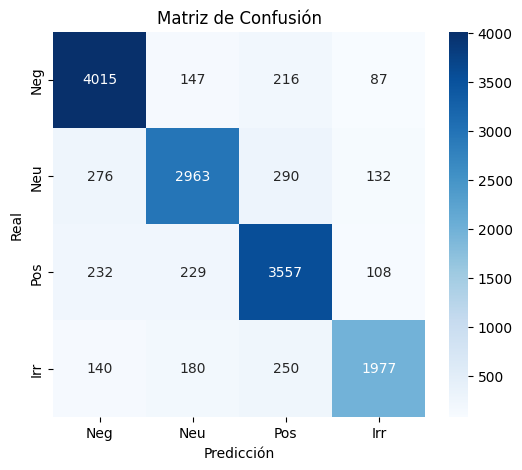

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neg", "Neu", "Pos", "Irr"],
            yticklabels=["Neg", "Neu", "Pos", "Irr"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


### Datos

* Exactitud global (accuracy): 85% → El modelo clasifica correctamente la mayoría de los tweets.

* Negative (Precisión 0.86, Recall 0.90, F1=0.88): Es la clase más fuerte del modelo. Identifica muy bien los tweets negativos, con un equilibrio excelente entre precisión y recall.

* Neutral (Precisión 0.84, Recall 0.81, F1=0.83): Buen desempeño, aunque a veces confunde tweets neutrales con otras clases (ligeramente menos recall).

* Positive (Precisión 0.82, Recall 0.86, F1=0.84): También sólido, pero con una ligera tendencia a confundir algunos positivos como neutrales o irrelevantes.

* Irrelevant (Precisión 0.86, Recall 0.78, F1=0.82): Aquí el recall es más bajo, o sea que el modelo se “pierde” algunos irrelevantes y los predice como neutrales o negativos.

* En conjunto, el macro promedio (0.84) y el weighted promedio (0.84–0.85) muestran que el rendimiento está balanceado entre las clases, sin que una domine en exceso.

# Predicciones con Twees nuevos 

In [54]:
import pandas as pd
from transformers import pipeline

# Crear pipeline con tu modelo entrenado
sentiment_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=1   # solo la mejor predicción
)

# Frases de prueba
frases = [
    "I absolutely love this game, it's amazing!",
    "This movie was boring and a waste of time.",
    "The concert was okay, nothing special.",
    "I don't care about this product at all.",
    "El servicio al cliente fue excelente",
]

# Obtener predicciones
preds = sentiment_pipeline(frases)

# Aplanar lista de listas y crear DataFrame
flat_preds = [p[0] if isinstance(p, list) else p for p in preds]
df_preds = pd.DataFrame(flat_preds)
df_preds["text"] = frases  # añadir la frase original

# Función para colorear etiquetas estilo semáforo 🚦 con texto oscuro
def color_labels(val):
    if val == "Positive":
        return "background-color: lightgreen; color: black"
    elif val == "Negative":
        return "background-color: salmon; color: black"
    elif val == "Neutral":
        return "background-color: khaki; color: black"
    elif val == "Irrelevant":
        return "background-color: lightblue; color: black"
    return "color: black"


# Mostrar tabla bonita con colores
df_preds[["text", "label", "score"]].style.applymap(color_labels, subset=["label"]).format({"score": "{:.2f}"})


Device set to use cuda:0
C:\Users\yasmi\AppData\Local\Temp\ipykernel_18688\907144285.py:43: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_preds[["text", "label", "score"]].style.applymap(color_labels, subset=["label"]).format({"score": "{:.2f}"})


,text,label,score
0,"I absolutely love this game, it's amazing!",Positive,0.98
1,This movie was boring and a waste of time.,Negative,0.96
2,"The concert was okay, nothing special.",Positive,0.90
3,I don't care about this product at all.,Negative,0.94
4,El servicio al cliente fue excelente,Positive,0.82
